# 1. Introdução

Objetivo: O objetivo deste projeto é montar um banco de dados SQL na plataforma
Google Cloud Platform (GCP), consumir essa base no Google Colab e transformá-la
em DataFrames para análise de dados. O tratamento dos dados será realizado 
conforme necessário, e técnicas estatísticas serão aplicadas para suportar
decisões informadas.

# 2. Arquitetura

Este projeto consiste em três partes principais:

    1. Montvalor_aluguelm do banco de dados no GCP.
    2. Consumo da base no Google Colab e transformação em DataFrames.
    3. Tratamento de dados e análise estatística.

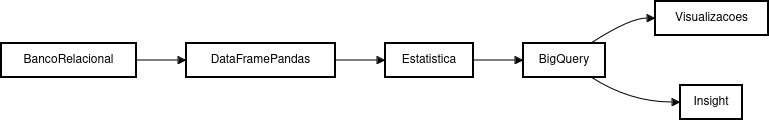

    

# 3. Passos para Montar o Banco de Dados no GCP

## 3.1. Criação do Banco de Dados SQL no GCP

1. Acesse o Google Cloud Console.
2. Navegue até a seção Cloud SQL e crie uma nova instância.
3. Escolha a versão do banco de dados (MySQL, PostgreSQL, etc.).
4. Importe a base de dados SQL fornecida, utilizando o comando de importação disponível no console ou por meio de gcloud

   ```bash
    gcloud auth login --no-launch-browser
    gcloud sql import sql mysql-soulcode gs://soulcode-analytics-data-bootcamp/projeto_logistica.sql
    ```
   

In [1]:
import os
import io
import math
import numpy as np
import pandas as pd
import mysql.connector
from mysql.connector import Error
from google.cloud import storage
from pyspark.sql import DataFrame, SparkSession
from unidecode import unidecode
from sqlalchemy import create_engine
from urllib.parse import quote_plus


from scipy import stats

from sqlalchemy import Column, Integer, Float, String, Boolean, DateTime, Text
from sqlalchemy.orm import declarative_base

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
credentials_path = "/home/jovyan/code/soulcode-434516-31276919e28c.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path

# 5. Consumindo o Banco de Dados no Google Colab

Configuração do Ambiente

1. Configure a conexão com o banco de dados no GCP

In [73]:
HOST = '34.16.33.165'
DB_LOCADORA = 'locadora'
DB_LOGISTICA = 'logistica'
DB_LOJA = 'loja'
DB_MARKETING_DIGITAL = 'marketing_digital'
DB_RH = 'recursos_humanos'
USER = 'soulcode'
PASSWORD = 'Soulcode@!12pass'

## 5.1. Database Locadora

In [4]:
engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB_LOCADORA}')
connection = engine.connect()

### 5.1.1 Transformação em DataFrames Pandas

In [5]:
query = """SELECT
    a.codaluguel AS codigo_aluguel,
    a.data_aluguel AS data_aluguel,
    c.nome AS nome_cliente,
    c.cidade AS cidade_cliente,
    c.sexo AS sexo_cliente,
    c.estado AS estado_cliente,
    c.estadocivil AS estadocivil_cliente,
    car.modelo AS modelo_carro,
    car.valor AS valor_aluguel,
    m.marca AS marca_carro
FROM
    aluguel a
INNER JOIN cliente c ON a.codcliente = c.codcliente
INNER JOIN carro car ON a.codcarro = car.codcarro
INNER JOIN marca m ON car.codmarca = m.codmarca;"""

df = pd.read_sql(query, connection)
df

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen


### 5.1.2. Tratamento de Dados

**Analisando o dataset**

Dimensão do dataset:

In [6]:
df.shape

(10, 10)

Verificação de dados faltantes:

In [7]:
df.isnull().sum()

codigo_aluguel         0
data_aluguel           0
nome_cliente           0
cidade_cliente         0
sexo_cliente           0
estado_cliente         0
estadocivil_cliente    0
modelo_carro           0
valor_aluguel          0
marca_carro            0
dtype: int64

Verficando informações sobre sobre dataframe incluindo index, tipo dos dados e
colunas não nulas e uso da memoria

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codigo_aluguel       10 non-null     int64  
 1   data_aluguel         10 non-null     object 
 2   nome_cliente         10 non-null     object 
 3   cidade_cliente       10 non-null     object 
 4   sexo_cliente         10 non-null     object 
 5   estado_cliente       10 non-null     object 
 6   estadocivil_cliente  10 non-null     object 
 7   modelo_carro         10 non-null     object 
 8   valor_aluguel        10 non-null     float64
 9   marca_carro          10 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 932.0+ bytes


Analisando o dataframe, para identificar o tipo que corresponde aos dados

In [9]:
df.head()

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat


In [10]:
df.tail()

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen


Verificando colunas numéricas com valores zerados

In [11]:
df.eq(0).sum()

codigo_aluguel         0
data_aluguel           0
nome_cliente           0
cidade_cliente         0
sexo_cliente           0
estado_cliente         0
estadocivil_cliente    0
modelo_carro           0
valor_aluguel          0
marca_carro            0
dtype: int64

Remover registro duplicados

Deletar registro duplicados

In [12]:
df = df.drop_duplicates()

 Conversão de Tipos de Dados

In [13]:
df['data_aluguel'] = pd.to_datetime(df['data_aluguel'], errors='coerce')
df['ano_aluguel'] = df['data_aluguel'].dt.year
df['mes_aluguel'] = df['data_aluguel'].dt.month
df['dia_aluguel'] = df['data_aluguel'].dt.day


### 5.1.3. Análise Estatística Descritiva

In [14]:
df.describe()

,codigo_aluguel,data_aluguel,valor_aluguel,ano_aluguel,mes_aluguel,dia_aluguel
count,10.00000,10,10.000000,10.0,10.0,10.000000
mean,5.50000,2023-04-10 19:12:00,132.000000,2023.0,4.0,10.800000
min,1.00000,2023-04-01 00:00:00,100.000000,2023.0,4.0,1.000000
25%,3.25000,2023-04-03 06:00:00,100.000000,2023.0,4.0,3.250000
50%,5.50000,2023-04-09 00:00:00,150.000000,2023.0,4.0,9.000000
75%,7.75000,2023-04-18 00:00:00,150.000000,2023.0,4.0,18.000000
max,10.00000,2023-04-25 00:00:00,170.000000,2023.0,4.0,25.000000
std,3.02765,NaN,28.205594,0.0,0.0,8.879439


In [15]:
# Matriz de correlação #TODO:estudar
# correlacao = df[['valor_aluguel', 'dia_aluguel']].corr()  # ou 'spearman' para correlação não linear
# correlacao

Boxplot e Identificação de Outliers

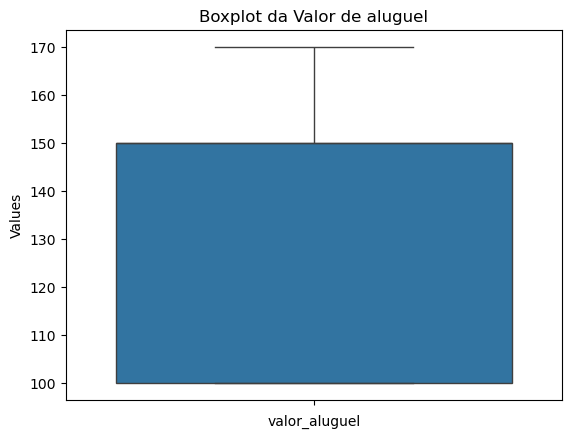

In [16]:
sns.boxplot(y='valor_aluguel', data=df)
plt.title('Boxplot da Valor de aluguel')
plt.xlabel('valor_aluguel')
plt.ylabel('Values')
plt.show()

Z-Score: Identifica outliers com base em quantos desvios padrão uma observação está distante da média

In [17]:
# z_scores = stats.zscore(df.select_dtypes(include=[float, int])) 
z_scores = stats.zscore(df['valor_aluguel'])
z_scores

0   -1.195896
1   -1.195896
2   -1.195896
3   -1.195896
4    0.672692
5    0.672692
6    0.672692
7    1.420127
8    0.672692
9    0.672692
Name: valor_aluguel, dtype: float64

In [18]:
outliers = df['valor_aluguel'][(z_scores > 3)]
outliers

Series([], Name: valor_aluguel, dtype: float64)

Histrograma para Frequência

In [19]:
n = len(df)
n

10

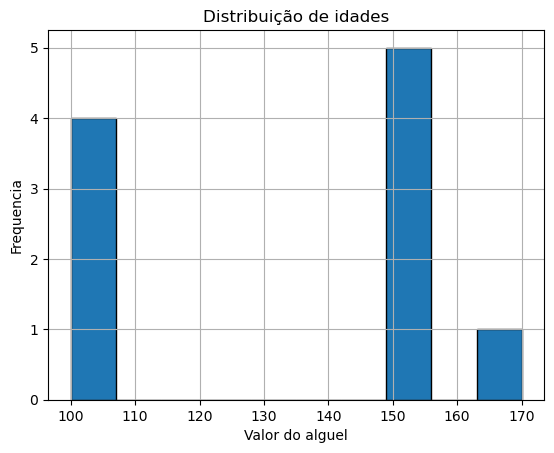

In [20]:
 
df['valor_aluguel'].hist(edgecolor='black')
plt.title('Distribuição de idades')
plt.xlabel('Valor do alguel')
plt.ylabel('Frequencia')
plt.show()


In [21]:
df.columns

Index(['codigo_aluguel', 'data_aluguel', 'nome_cliente', 'cidade_cliente',
       'sexo_cliente', 'estado_cliente', 'estadocivil_cliente', 'modelo_carro',
       'valor_aluguel', 'marca_carro', 'ano_aluguel', 'mes_aluguel',
       'dia_aluguel'],
      dtype='object')

Análise de Séries Temporais

In [22]:
df_resample = df[['data_aluguel', 'valor_aluguel']].set_index('data_aluguel').sort_index()
df_resample

,valor_aluguel
data_aluguel,
2023-04-01,150.0
2023-04-02,100.0
2023-04-03,100.0
2023-04-04,170.0
2023-04-05,150.0
2023-04-13,150.0
2023-04-15,100.0
2023-04-19,150.0
2023-04-21,150.0


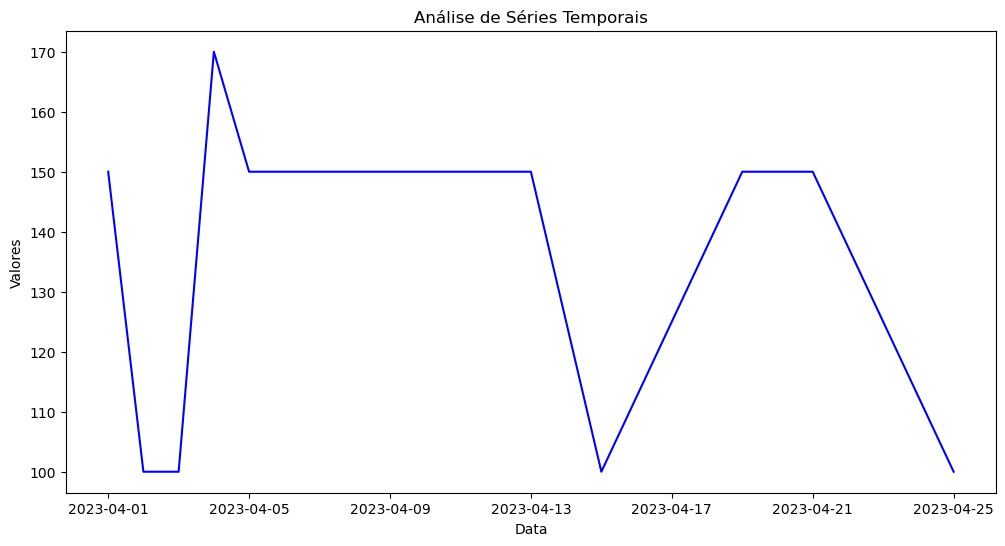

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df_resample.index, df_resample['valor_aluguel'], color='blue')
plt.title('Análise de Séries Temporais')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.show()

### 5.1.4. Carregar o Dataframe Pandas no BigQuery

In [24]:
from google.cloud import bigquery
project_id = 'soulcode-434516'
dataset_id = 'atividade_1_est_bd'

In [25]:
client = bigquery.Client()

In [26]:
def create_dataset_bigQuery(client, dataset_id, location="US"):
    """Cria um dataset no BigQuery.

    Args:
        client: Um objeto cliente do BigQuery.
        dataset_id: O ID do dataset a ser criado.
        location: A localização geográfica do dataset.

    Returns:
        Um objeto Dataset representando o dataset criado.

    Raises:
        Exception: Se ocorrer algum erro durante a criação do dataset.
    """

    dataset_ref = client.dataset(dataset_id)
    dataset = bigquery.Dataset(dataset_ref)
    dataset.location = location

    try:
        dataset = client.create_dataset(dataset)
        print(f"Dataset {dataset.dataset_id} criado com sucesso!")
        return dataset
    except Exception as e:
        raise

In [27]:
# Criar o Dataset
dataset = None
try:
    dataset = create_dataset_bigQuery(client, dataset_id)
except Exception as e:
    print(f"Erro ao criar o dataset: {e}")

Erro ao criar o dataset: 409 POST https://bigquery.googleapis.com/bigquery/v2/projects/soulcode-434516/datasets?prettyPrint=false: Already Exists: Dataset soulcode-434516:atividade_1_est_bd


In [28]:
#TODO: Criar schema Bigquery porem já está formatado com o dataframe pandas
# table_id = "soulcode-434516.atividade_1_est_bd.tb_locadora"
table_locadora_id = f"{project_id}.{dataset_id}.tb_locadora"
if dataset:
    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
    )
    
    job = client.load_table_from_dataframe(df,table_locadora_id, job_config=job_config)
    job.result()
else:
    print('Não criado')


Não criado


In [29]:
query = f"SELECT * FROM `{table_locadora_id}`"

query_job = client.query(query)
results = query_job.result().to_dataframe()
results


/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro,ano_aluguel,mes_aluguel,dia_aluguel
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,2
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,3
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford,2023,4,15
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford,2023,4,25
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat,2023,4,1
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,19
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,21
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet,2023,4,4
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen,2023,4,5
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen,2023,4,13


## 5.2. Database Logistica

In [30]:
engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB_LOGISTICA}')
connection = engine.connect()
connection

### 5.2.1 Transformação em DataFrames Pandas

In [31]:
query = """SELECT
    P.ID_Pedido AS Pedido_ID,
    P.Data_Pedido AS data_pedido,
    P.Data_Entrega_Estimada AS data_entrega_estimada,
    P.Data_Entrega_Real AS data_entrega_real,
    P.Distancia_km AS distancia_km,
    P.Custo_Transporte AS custo_transporte,
    P.Peso_kg AS peso_kg,
    P.Regiao AS regiao,
    M.Nome AS nome_motorista,
    M.Idade as idade_motorista,
    M.Tempo_de_Empresa AS tempo_empresa_motorista,
    M.Regiao AS regiao_motorista,
    M.Avaliacao_Desempenho AS avaliacao_desempenho_motorista,
    V.Tipo AS tipo_veiculo,
    V.Capacidade_kg AS capacidade_kg_veiculo,
    V.Custo_Manutencao_Mensal AS custo_manutencao_mensal_veiculo,
    V.Consumo_Combustivel_km_l AS consumo_combustivel_km_l
FROM
    Pedidos P
INNER JOIN Motoristas M ON P.Motorista = M.ID_Motorista
INNER JOIN Veiculos V ON P.Veiculo = V.ID_Veiculo;"""

df = pd.read_sql(query, connection)
df

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,regiao,nome_motorista,idade_motorista,tempo_empresa_motorista,regiao_motorista,avaliacao_desempenho_motorista,tipo_veiculo,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
0,4,2023-01-04,2023-01-08,2023-01-09,602.6720,557.714,449.7840,Justinshire,James Larson,45,6,Lake Nicole,1.12926,Caminhão,986.757,839.116,8.07568
1,8,2023-01-08,2023-01-12,2023-01-13,867.5140,779.996,333.4330,North Sarahaven,Daniel Hunt,55,8,Masontown,4.67671,Caminhão,986.757,839.116,8.07568
2,13,2023-01-13,2023-01-17,2023-01-18,834.1180,936.728,327.7210,North Chelsea,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,986.757,839.116,8.07568
3,19,2023-01-19,2023-01-23,2023-01-24,437.6260,903.303,326.5680,Jamestown,Craig Peterson,27,28,North Curtisland,4.50665,Caminhão,986.757,839.116,8.07568
4,20,2023-01-20,2023-01-24,2023-01-25,298.3170,585.408,425.3660,Davidhaven,Amber Stone,56,8,Martinstad,2.81296,Caminhão,986.757,839.116,8.07568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,61,2023-03-02,2023-03-06,2023-03-07,394.7910,431.005,309.4290,East Dustin,Jennifer Moss,47,28,Hallville,1.65934,Caminhão,112.305,1584.880,12.47250
96,64,2023-03-05,2023-03-09,2023-03-10,363.1860,582.197,261.5730,Nelsonhaven,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.880,12.47250
97,83,2023-03-24,2023-03-28,2023-03-29,337.5890,932.224,190.9140,West Mariamouth,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,112.305,1584.880,12.47250
98,84,2023-03-25,2023-03-29,2023-03-30,72.9228,889.605,51.5211,Alexanderland,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.880,12.47250


### 5.2.2. Tratamento de Dados

In [32]:
df.shape

(100, 17)

In [33]:
df.isnull().sum()

Pedido_ID                          0
data_pedido                        0
data_entrega_estimada              0
data_entrega_real                  0
distancia_km                       0
custo_transporte                   0
peso_kg                            0
regiao                             0
nome_motorista                     0
idade_motorista                    0
tempo_empresa_motorista            0
regiao_motorista                   0
avaliacao_desempenho_motorista     0
tipo_veiculo                       0
capacidade_kg_veiculo              0
custo_manutencao_mensal_veiculo    0
consumo_combustivel_km_l           0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Pedido_ID                        100 non-null    int64         
 1   data_pedido                      100 non-null    datetime64[ns]
 2   data_entrega_estimada            100 non-null    datetime64[ns]
 3   data_entrega_real                100 non-null    datetime64[ns]
 4   distancia_km                     100 non-null    float64       
 5   custo_transporte                 100 non-null    float64       
 6   peso_kg                          100 non-null    float64       
 7   regiao                           100 non-null    object        
 8   nome_motorista                   100 non-null    object        
 9   idade_motorista                  100 non-null    int64         
 10  tempo_empresa_motorista          100 non-null    int64         

In [35]:
df.head()

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,regiao,nome_motorista,idade_motorista,tempo_empresa_motorista,regiao_motorista,avaliacao_desempenho_motorista,tipo_veiculo,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
0,4,2023-01-04,2023-01-08,2023-01-09,602.672,557.714,449.784,Justinshire,James Larson,45,6,Lake Nicole,1.12926,Caminhão,986.757,839.116,8.07568
1,8,2023-01-08,2023-01-12,2023-01-13,867.514,779.996,333.433,North Sarahaven,Daniel Hunt,55,8,Masontown,4.67671,Caminhão,986.757,839.116,8.07568
2,13,2023-01-13,2023-01-17,2023-01-18,834.118,936.728,327.721,North Chelsea,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,986.757,839.116,8.07568
3,19,2023-01-19,2023-01-23,2023-01-24,437.626,903.303,326.568,Jamestown,Craig Peterson,27,28,North Curtisland,4.50665,Caminhão,986.757,839.116,8.07568
4,20,2023-01-20,2023-01-24,2023-01-25,298.317,585.408,425.366,Davidhaven,Amber Stone,56,8,Martinstad,2.81296,Caminhão,986.757,839.116,8.07568


In [36]:
df.tail()

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,regiao,nome_motorista,idade_motorista,tempo_empresa_motorista,regiao_motorista,avaliacao_desempenho_motorista,tipo_veiculo,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
95,61,2023-03-02,2023-03-06,2023-03-07,394.7910,431.005,309.4290,East Dustin,Jennifer Moss,47,28,Hallville,1.65934,Caminhão,112.305,1584.88,12.4725
96,64,2023-03-05,2023-03-09,2023-03-10,363.1860,582.197,261.5730,Nelsonhaven,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.88,12.4725
97,83,2023-03-24,2023-03-28,2023-03-29,337.5890,932.224,190.9140,West Mariamouth,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,112.305,1584.88,12.4725
98,84,2023-03-25,2023-03-29,2023-03-30,72.9228,889.605,51.5211,Alexanderland,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.88,12.4725
99,89,2023-03-30,2023-04-03,2023-04-04,888.3410,576.686,146.8380,Lake Adrianastad,Amber Stone,56,8,Martinstad,2.81296,Caminhão,112.305,1584.88,12.4725


In [37]:
df.eq(0).sum()

Pedido_ID                          0
data_pedido                        0
data_entrega_estimada              0
data_entrega_real                  0
distancia_km                       0
custo_transporte                   0
peso_kg                            0
regiao                             0
nome_motorista                     0
idade_motorista                    0
tempo_empresa_motorista            0
regiao_motorista                   0
avaliacao_desempenho_motorista     0
tipo_veiculo                       0
capacidade_kg_veiculo              0
custo_manutencao_mensal_veiculo    0
consumo_combustivel_km_l           0
dtype: int64

In [38]:
df = df.drop_duplicates()

### 5.2.3. Análise Estatística Descritiva

In [39]:
df.describe()

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,idade_motorista,tempo_empresa_motorista,avaliacao_desempenho_motorista,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
count,100.000000,100,100,100,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,50.500000,2023-02-19 12:00:00,2023-02-23 12:00:00,2023-02-24 12:00:00,475.478925,548.04859,261.212665,40.97000,16.930000,2.838906,472.536260,2893.45572,9.479980
min,1.000000,2023-01-01 00:00:00,2023-01-05 00:00:00,2023-01-06 00:00:00,15.466900,106.25700,7.505480,25.00000,4.000000,1.129260,112.305000,839.11600,5.332770
25%,25.750000,2023-01-25 18:00:00,2023-01-29 18:00:00,2023-01-30 18:00:00,201.268750,317.80425,142.055250,36.00000,8.000000,2.039800,157.161000,2200.33000,5.703450
50%,50.500000,2023-02-19 12:00:00,2023-02-23 12:00:00,2023-02-24 12:00:00,469.501000,555.06250,283.465000,40.00000,17.000000,2.655790,446.377500,3018.86500,8.440025
75%,75.250000,2023-03-16 06:00:00,2023-03-20 06:00:00,2023-03-21 06:00:00,732.901000,789.56550,377.421500,45.00000,26.000000,3.324650,774.620000,3794.30500,12.472500
max,100.000000,2023-04-10 00:00:00,2023-04-14 00:00:00,2023-04-15 00:00:00,987.018000,987.08500,495.077000,59.00000,28.000000,4.762130,986.757000,4609.25000,18.173300
std,29.011492,NaN,NaN,NaN,294.514511,263.80012,145.246050,8.27245,8.638948,1.075924,320.086021,1155.22145,3.957608


### 5.2.4. Carregar o Dataframe Pandas no BigQuery

In [40]:

table_locadora_id = f"{project_id}.{dataset_id}.tb_logistica"

job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)
    
job = client.load_table_from_dataframe(df,table_locadora_id, job_config=job_config)
job.result()

LoadJob<project=soulcode-434516, location=US, id=8d7ed2b6-b7d7-4460-835b-aaa1c4d8097f>

In [41]:
query = f"SELECT * FROM `{table_locadora_id}`"

query_job = client.query(query)
results = query_job.result().to_dataframe()
results


/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,regiao,nome_motorista,idade_motorista,tempo_empresa_motorista,regiao_motorista,avaliacao_desempenho_motorista,tipo_veiculo,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
0,69,2023-03-10,2023-03-14,2023-03-15,83.8051,136.698,182.94800,Myersbury,Tim Martin,38,4,Elizabethtown,2.66656,Moto,774.620,2904.560,9.12098
1,77,2023-03-18,2023-03-22,2023-03-23,773.5580,721.844,400.15600,South Joshua,Tim Martin,38,4,Elizabethtown,2.66656,Caminhão,453.690,3874.600,8.10841
2,96,2023-04-06,2023-04-10,2023-04-11,498.8580,414.289,263.51000,Turnerville,Tim Martin,38,4,Elizabethtown,2.66656,Moto,220.467,2200.330,5.33277
3,13,2023-01-13,2023-01-17,2023-01-18,834.1180,936.728,327.72100,North Chelsea,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,986.757,839.116,8.07568
4,53,2023-02-22,2023-02-26,2023-02-27,940.1040,230.405,426.31300,Connerfurt,Jason Padilla,36,5,New Jeffreyborough,4.11041,Van,439.065,3612.710,8.77164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,35,2023-02-04,2023-02-08,2023-02-09,965.9760,948.619,101.64500,Port Keithside,Craig Peterson,27,28,North Curtisland,4.50665,Van,846.248,4609.250,18.17330
96,94,2023-04-04,2023-04-08,2023-04-09,565.6640,669.791,183.29400,New Stephanie,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,986.757,839.116,8.07568
97,9,2023-01-09,2023-01-13,2023-01-14,605.1040,305.918,7.50548,Belltown,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,157.161,3767.540,5.70345
98,64,2023-03-05,2023-03-09,2023-03-10,363.1860,582.197,261.57300,Nelsonhaven,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.880,12.47250


## 5.3. Database Loja

In [42]:
engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB_LOJA}')
connection = engine.connect()
connection

### 5.3.1 Transformação em DataFrames Pandas

In [43]:
query = """
SELECT 
	V.id_venda,
	V.quantidade AS qtd_vendas,
	V.data AS data_vendas,
	C.nome AS nome_cliente,
	C.telefone AS telefone_cliente,
	C.cidade AS cidade_cliente,
	C.email AS email_cliente,
	C.genero AS genero_cliente,
	C.endereco AS endereco_cliente,
	C.renda AS renda_cliente,
	C.data_nascimento AS data_nasc_cliente,
	F.nome AS nome_funcionario,
	F.data_nascimento AS data_nasc_funcionario,
	F.genero AS data_nasc_funcionario,
	F.estado_civil AS estado_civil_funcionario,
	F.dependentes AS dependentes_funcionario,
	F.cargo AS cargo_funcionario,
	F.salario AS salario_funcionario,
	P.nome AS produto_nome,
	P.preco AS produto_preco,
	CAT.nome AS categoria_nome,
	FO.nome AS fornecedor_nome,
	FO.cidade AS fornecedor_cidade,
	FO.endereco AS fornecedor_endereco,
	FO.cnpj AS fornecedor_cnpj
FROM 
	vendas V
	INNER JOIN clientes C ON C.id_cliente = V.id_cliente
	INNER JOIN funcionarios F ON F.id_funcionario = V.id_funcionario
	INNER JOIN produtos P ON P.id_produto = V.id_produto
	INNER JOIN categorias CAT ON P.id_categoria = CAT.id_categoria
	INNER JOIN fornecedores FO ON P.id_fornecedor = FO.id_fornecedor;
"""

df = pd.read_sql(query, connection)
df

,id_venda,qtd_vendas,data_vendas,nome_cliente,telefone_cliente,cidade_cliente,email_cliente,genero_cliente,endereco_cliente,renda_cliente,...,dependentes_funcionario,cargo_funcionario,salario_funcionario,produto_nome,produto_preco,categoria_nome,fornecedor_nome,fornecedor_cidade,fornecedor_endereco,fornecedor_cnpj
0,4,1,2024-07-04,Ana Souza,(51) 98765-7654,Porto Alegre,ana@email.com,Feminino,"Av. D, 987",3800.0,...,1,Caixa,2800.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
1,31,1,2024-07-31,Marcelo Lima,(11) 98765-4321,São Paulo,marcelo@email.com,Masculino,"Av. E1, 1098",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
2,51,1,2024-08-20,Felipe Santos,(11) 98765-4321,São Paulo,felipe@email.com,Masculino,"Av. K, 567",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
3,71,1,2024-09-09,Marcelo Lima,(11) 98765-4321,São Paulo,marcelo@email.com,Masculino,"Av. E1, 1098",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
4,91,1,2024-09-29,Felipe Santos,(11) 98765-4321,São Paulo,felipe@email.com,Masculino,"Av. K, 567",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,38,1,2024-08-07,Renata Oliveira,(31) 98765-7654,Belo Horizonte,renata@email.com,Feminino,"Rua L1, 987",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
119,58,1,2024-08-27,Vanessa Souza,(31) 98765-7654,Belo Horizonte,vanessa@email.com,Feminino,"Rua R, 234",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
120,78,1,2024-09-16,Renata Oliveira,(31) 98765-7654,Belo Horizonte,renata@email.com,Feminino,"Rua L1, 987",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
121,98,1,2024-10-06,Vanessa Souza,(31) 98765-7654,Belo Horizonte,vanessa@email.com,Feminino,"Rua R, 234",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876


### 5.3.2. Tratamento de Dados

Analisando o dataset

Dimensão do dataset

In [44]:
df.shape

(123, 25)

Verificação de dados faltantes

In [45]:
df.isnull().sum()

id_venda                    0
qtd_vendas                  0
data_vendas                 0
nome_cliente                0
telefone_cliente            0
cidade_cliente              0
email_cliente               0
genero_cliente              0
endereco_cliente            0
renda_cliente               0
data_nasc_cliente           0
nome_funcionario            0
data_nasc_funcionario       0
data_nasc_funcionario       0
estado_civil_funcionario    0
dependentes_funcionario     0
cargo_funcionario           0
salario_funcionario         0
produto_nome                0
produto_preco               0
categoria_nome              0
fornecedor_nome             0
fornecedor_cidade           0
fornecedor_endereco         0
fornecedor_cnpj             0
dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_venda                  123 non-null    int64  
 1   qtd_vendas                123 non-null    int64  
 2   data_vendas               123 non-null    object 
 3   nome_cliente              123 non-null    object 
 4   telefone_cliente          123 non-null    object 
 5   cidade_cliente            123 non-null    object 
 6   email_cliente             123 non-null    object 
 7   genero_cliente            123 non-null    object 
 8   endereco_cliente          123 non-null    object 
 9   renda_cliente             123 non-null    float64
 10  data_nasc_cliente         123 non-null    object 
 11  nome_funcionario          123 non-null    object 
 12  data_nasc_funcionario     123 non-null    object 
 13  data_nasc_funcionario     123 non-null    object 
 14  estado_civ

Analisando o dataframe, pra identificar o tipo que corresponde aos dados

In [47]:
df.head()

,id_venda,qtd_vendas,data_vendas,nome_cliente,telefone_cliente,cidade_cliente,email_cliente,genero_cliente,endereco_cliente,renda_cliente,...,dependentes_funcionario,cargo_funcionario,salario_funcionario,produto_nome,produto_preco,categoria_nome,fornecedor_nome,fornecedor_cidade,fornecedor_endereco,fornecedor_cnpj
0,4,1,2024-07-04,Ana Souza,(51) 98765-7654,Porto Alegre,ana@email.com,Feminino,"Av. D, 987",3800.0,...,1,Caixa,2800.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
1,31,1,2024-07-31,Marcelo Lima,(11) 98765-4321,São Paulo,marcelo@email.com,Masculino,"Av. E1, 1098",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
2,51,1,2024-08-20,Felipe Santos,(11) 98765-4321,São Paulo,felipe@email.com,Masculino,"Av. K, 567",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
3,71,1,2024-09-09,Marcelo Lima,(11) 98765-4321,São Paulo,marcelo@email.com,Masculino,"Av. E1, 1098",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
4,91,1,2024-09-29,Felipe Santos,(11) 98765-4321,São Paulo,felipe@email.com,Masculino,"Av. K, 567",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876


In [48]:
df.tail()

,id_venda,qtd_vendas,data_vendas,nome_cliente,telefone_cliente,cidade_cliente,email_cliente,genero_cliente,endereco_cliente,renda_cliente,...,dependentes_funcionario,cargo_funcionario,salario_funcionario,produto_nome,produto_preco,categoria_nome,fornecedor_nome,fornecedor_cidade,fornecedor_endereco,fornecedor_cnpj
118,38,1,2024-08-07,Renata Oliveira,(31) 98765-7654,Belo Horizonte,renata@email.com,Feminino,"Rua L1, 987",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
119,58,1,2024-08-27,Vanessa Souza,(31) 98765-7654,Belo Horizonte,vanessa@email.com,Feminino,"Rua R, 234",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
120,78,1,2024-09-16,Renata Oliveira,(31) 98765-7654,Belo Horizonte,renata@email.com,Feminino,"Rua L1, 987",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
121,98,1,2024-10-06,Vanessa Souza,(31) 98765-7654,Belo Horizonte,vanessa@email.com,Feminino,"Rua R, 234",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
122,118,1,2024-10-26,Renata Oliveira,(31) 98765-7654,Belo Horizonte,renata@email.com,Feminino,"Rua L1, 987",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876


In [49]:
df.eq(0).sum()

id_venda                     0
qtd_vendas                   0
data_vendas                  0
nome_cliente                 0
telefone_cliente             0
cidade_cliente               0
email_cliente                0
genero_cliente               0
endereco_cliente             0
renda_cliente                0
data_nasc_cliente            0
nome_funcionario             0
data_nasc_funcionario        0
data_nasc_funcionario        0
estado_civil_funcionario     0
dependentes_funcionario     49
cargo_funcionario            0
salario_funcionario          0
produto_nome                 0
produto_preco                0
categoria_nome               0
fornecedor_nome              0
fornecedor_cidade            0
fornecedor_endereco          0
fornecedor_cnpj              0
dtype: int64

In [50]:
# df.drop('dependentes_funcionario', axis=1, inplace=True)
df

,id_venda,qtd_vendas,data_vendas,nome_cliente,telefone_cliente,cidade_cliente,email_cliente,genero_cliente,endereco_cliente,renda_cliente,...,dependentes_funcionario,cargo_funcionario,salario_funcionario,produto_nome,produto_preco,categoria_nome,fornecedor_nome,fornecedor_cidade,fornecedor_endereco,fornecedor_cnpj
0,4,1,2024-07-04,Ana Souza,(51) 98765-7654,Porto Alegre,ana@email.com,Feminino,"Av. D, 987",3800.0,...,1,Caixa,2800.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
1,31,1,2024-07-31,Marcelo Lima,(11) 98765-4321,São Paulo,marcelo@email.com,Masculino,"Av. E1, 1098",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
2,51,1,2024-08-20,Felipe Santos,(11) 98765-4321,São Paulo,felipe@email.com,Masculino,"Av. K, 567",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
3,71,1,2024-09-09,Marcelo Lima,(11) 98765-4321,São Paulo,marcelo@email.com,Masculino,"Av. E1, 1098",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
4,91,1,2024-09-29,Felipe Santos,(11) 98765-4321,São Paulo,felipe@email.com,Masculino,"Av. K, 567",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,38,1,2024-08-07,Renata Oliveira,(31) 98765-7654,Belo Horizonte,renata@email.com,Feminino,"Rua L1, 987",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
119,58,1,2024-08-27,Vanessa Souza,(31) 98765-7654,Belo Horizonte,vanessa@email.com,Feminino,"Rua R, 234",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
120,78,1,2024-09-16,Renata Oliveira,(31) 98765-7654,Belo Horizonte,renata@email.com,Feminino,"Rua L1, 987",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
121,98,1,2024-10-06,Vanessa Souza,(31) 98765-7654,Belo Horizonte,vanessa@email.com,Feminino,"Rua R, 234",4000.0,...,0,Vendedora,3000.0,Perfume Masculino,80.0,Cosméticos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876


In [51]:
df.drop_duplicates(inplace=True)

### 5.3.3 Análise Estastitica Descritiva

In [52]:
df.describe()

,id_venda,qtd_vendas,renda_cliente,dependentes_funcionario,salario_funcionario,produto_preco,fornecedor_cnpj
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,62.000000,1.560976,4895.121951,1.105691,4027.642276,619.268293,4690.617886
std,35.651087,0.748182,1134.976974,1.046564,1428.532482,922.178382,3252.361202
min,1.000000,1.000000,3200.000000,0.000000,2800.000000,8.000000,1234.000000
25%,31.500000,1.000000,4000.000000,0.000000,3000.000000,25.000000,1234.000000
50%,62.000000,1.000000,4500.000000,1.000000,3400.000000,100.000000,5678.000000
75%,92.500000,2.000000,5800.000000,2.000000,6000.000000,1500.000000,5678.000000
max,123.000000,3.000000,7000.000000,3.000000,6500.000000,3000.000000,9876.000000


Boxplot e Identificação de Outliers

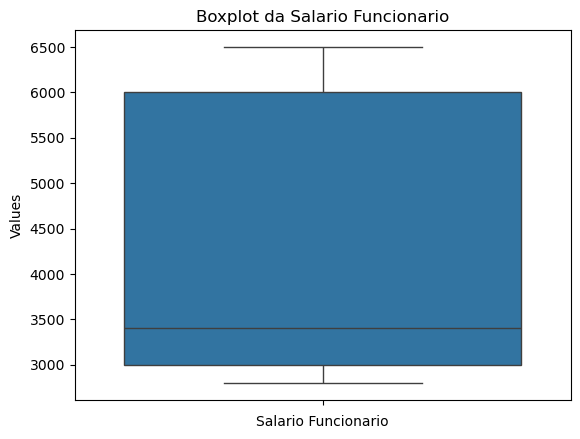

In [53]:
sns.boxplot(y='salario_funcionario', data=df)
plt.title('Boxplot da Salario Funcionario')
plt.xlabel('Salario Funcionario')
plt.ylabel('Values')
plt.show()

### 5.3.4 Carregar o Dataframe Pandas no BigQuery

In [54]:
cols = df.columns
duplicated_cols = cols[cols.duplicated()]
df.drop(df[duplicated_cols], axis=1, inplace=True)
df.shape

(123, 23)

In [55]:

table_loja_id = f"{project_id}.{dataset_id}.tb_loja"

job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)
    
job = client.load_table_from_dataframe(df,table_loja_id, job_config=job_config)
job.result()

LoadJob<project=soulcode-434516, location=US, id=3f8c7a51-ea72-4208-b8d7-aef1e3cd2db5>

In [56]:
query = f"SELECT * FROM `{table_loja_id}`"

query_job = client.query(query)
results = query_job.result().to_dataframe()
results


/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,id_venda,qtd_vendas,data_vendas,nome_cliente,telefone_cliente,cidade_cliente,email_cliente,genero_cliente,endereco_cliente,renda_cliente,...,dependentes_funcionario,cargo_funcionario,salario_funcionario,produto_nome,produto_preco,categoria_nome,fornecedor_nome,fornecedor_cidade,fornecedor_endereco,fornecedor_cnpj
0,1,2,2024-07-01,João Silva,(11) 98765-4321,São Paulo,joao@email.com,Masculino,"Rua A, 123",5000.0,...,2,Vendedor,3500.0,Smartphone X,1500.0,Eletrônicos,Fornecedor A,São Paulo,"Rua G, 234",1234
1,41,1,2024-08-10,João Silva,(11) 98765-4321,São Paulo,joao@email.com,Masculino,"Rua A, 123",5000.0,...,0,Vendedor,3400.0,Smartphone X,1500.0,Eletrônicos,Fornecedor A,São Paulo,"Rua G, 234",1234
2,81,1,2024-09-19,João Silva,(11) 98765-4321,São Paulo,joao@email.com,Masculino,"Rua A, 123",5000.0,...,0,Vendedor,3400.0,Smartphone X,1500.0,Eletrônicos,Fornecedor A,São Paulo,"Rua G, 234",1234
3,121,1,2024-10-29,João Silva,(11) 98765-4321,São Paulo,joao@email.com,Masculino,"Rua A, 123",5000.0,...,0,Vendedor,3400.0,Smartphone X,1500.0,Eletrônicos,Fornecedor A,São Paulo,"Rua G, 234",1234
4,31,1,2024-07-31,Marcelo Lima,(11) 98765-4321,São Paulo,marcelo@email.com,Masculino,"Av. E1, 1098",5800.0,...,0,Vendedor,3400.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,99,1,2024-10-07,Fernando Oliveira,(51) 98765-6543,Porto Alegre,fernando@email.com,Masculino,"Av. S, 987",7000.0,...,2,Caixa,2800.0,Blusa de Frio,80.0,Roupas,Fornecedor C,Belo Horizonte,"Rua I, 890",5678
119,119,1,2024-10-27,Thiago Martins,(51) 98765-6543,Porto Alegre,thiago@email.com,Masculino,"Av. M1, 321",7000.0,...,2,Caixa,2800.0,Blusa de Frio,80.0,Roupas,Fornecedor C,Belo Horizonte,"Rua I, 890",5678
120,4,1,2024-07-04,Ana Souza,(51) 98765-7654,Porto Alegre,ana@email.com,Feminino,"Av. D, 987",3800.0,...,1,Caixa,2800.0,Notebook Y,3000.0,Eletrônicos,Fornecedor B,Rio de Janeiro,"Av. H, 567",9876
121,44,3,2024-08-13,Ana Souza,(51) 98765-7654,Porto Alegre,ana@email.com,Feminino,"Av. D, 987",3800.0,...,0,Gerente,6000.0,"Monitor LED 24""",800.0,Eletrônicos,Fornecedor A,São Paulo,"Rua G, 234",1234


## 5.4 Database Marketing Digital

In [57]:
engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB_MARKETING_DIGITAL}')
connection = engine.connect()


### 5.4.1. Transformação em Dataframes Pandas

In [58]:
query = """SELECT 
C.ID_Campanha,
C.Plataforma AS campanhas_plataforma,
C.Data_Inicio AS campanha_inicio,
C.Data_Fim AS campanha_fim,
C.Investimento_Total AS campanhas_investimento,
C.Impressoes AS campanhas_impressoes,
C.Cliques AS campanhas_cliques,
C.Conversoes AS campanhas_conversoes,
C.Regiao_Alvo AS campanhas_regioes_alvos,
C.Segmento_Alvo AS campanhas_segemento_alvo_interesses,
P.Nome AS plataformas_nome,
P.Custo_por_Clique AS plataformas_custo_clique,
P.Custo_por_Impressao AS plataformas_custo_impressao,
P.Conversoes_Totais AS plataformas_conversoes_totais,
U.idade AS usuario_idade,
U.Genero AS usuario_genero,
U.Localizacao AS usuario_localizacao,
U.Historico_de_Compras AS usuario_hist_compras,
U.Tempo_de_Engajamento AS usuario_tempo_engajamento
FROM Campanhas C
INNER JOIN Plataformas P ON C.Plataforma = P.Nome
INNER JOIN Usuarios U ON C.Segmento_Alvo = U.Interesses;"""

df = pd.read_sql(query, connection)

### 5.4.2. Tratamento de dados

Analisando o dataset

Dimensão do dataset

In [59]:
df.shape

(3217, 19)

Verificação de dados faltantes

In [60]:
df.isnull().sum()

ID_Campanha                            0
campanhas_plataforma                   0
campanha_inicio                        0
campanha_fim                           0
campanhas_investimento                 0
campanhas_impressoes                   0
campanhas_cliques                      0
campanhas_conversoes                   0
campanhas_regioes_alvos                0
campanhas_segemento_alvo_interesses    0
plataformas_nome                       0
plataformas_custo_clique               0
plataformas_custo_impressao            0
plataformas_conversoes_totais          0
usuario_idade                          0
usuario_genero                         0
usuario_localizacao                    0
usuario_hist_compras                   0
usuario_tempo_engajamento              0
dtype: int64

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3217 entries, 0 to 3216
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ID_Campanha                          3217 non-null   int64         
 1   campanhas_plataforma                 3217 non-null   object        
 2   campanha_inicio                      3217 non-null   datetime64[ns]
 3   campanha_fim                         3217 non-null   datetime64[ns]
 4   campanhas_investimento               3217 non-null   float64       
 5   campanhas_impressoes                 3217 non-null   int64         
 6   campanhas_cliques                    3217 non-null   int64         
 7   campanhas_conversoes                 3217 non-null   int64         
 8   campanhas_regioes_alvos              3217 non-null   object        
 9   campanhas_segemento_alvo_interesses  3217 non-null   object        
 10  plataformas_

In [62]:
df.head()

,ID_Campanha,campanhas_plataforma,campanha_inicio,campanha_fim,campanhas_investimento,campanhas_impressoes,campanhas_cliques,campanhas_conversoes,campanhas_regioes_alvos,campanhas_segemento_alvo_interesses,plataformas_nome,plataformas_custo_clique,plataformas_custo_impressao,plataformas_conversoes_totais,usuario_idade,usuario_genero,usuario_localizacao,usuario_hist_compras,usuario_tempo_engajamento
0,99,Facebook,2023-04-09,2023-04-15,1785.61,67656,3801,953,Patriciaton,Tecnologia,Facebook,0.662722,0.017888,5399,44,Masculino,Romerotown,14,18.9176
1,97,LinkedIn,2023-04-07,2023-04-13,7365.07,11789,788,744,Gloriaview,Tecnologia,LinkedIn,2.120610,0.037497,3367,44,Masculino,Romerotown,14,18.9176
2,94,Instagram,2023-04-04,2023-04-10,2795.56,1922,1066,191,Mcdanielfurt,Tecnologia,Instagram,1.684010,0.059842,1789,44,Masculino,Romerotown,14,18.9176
3,89,LinkedIn,2023-03-30,2023-04-05,5289.58,72324,6420,500,West Rachelland,Tecnologia,LinkedIn,2.120610,0.037497,3367,44,Masculino,Romerotown,14,18.9176
4,88,LinkedIn,2023-03-29,2023-04-04,5815.33,81910,6075,823,Lake Sabrina,Tecnologia,LinkedIn,2.120610,0.037497,3367,44,Masculino,Romerotown,14,18.9176


In [63]:
df.tail()

,ID_Campanha,campanhas_plataforma,campanha_inicio,campanha_fim,campanhas_investimento,campanhas_impressoes,campanhas_cliques,campanhas_conversoes,campanhas_regioes_alvos,campanhas_segemento_alvo_interesses,plataformas_nome,plataformas_custo_clique,plataformas_custo_impressao,plataformas_conversoes_totais,usuario_idade,usuario_genero,usuario_localizacao,usuario_hist_compras,usuario_tempo_engajamento
3212,16,LinkedIn,2023-01-16,2023-01-22,5604.91,20216,2991,327,Howardchester,Tecnologia,LinkedIn,2.12061,0.037497,3367,23,Outro,West Joshualand,55,22.9028
3213,12,Google,2023-01-12,2023-01-18,3894.24,35387,7963,444,Williamborough,Tecnologia,Google,1.86408,0.094326,7674,23,Outro,West Joshualand,55,22.9028
3214,9,LinkedIn,2023-01-09,2023-01-15,9047.96,3219,7426,150,Greenehaven,Tecnologia,LinkedIn,2.12061,0.037497,3367,23,Outro,West Joshualand,55,22.9028
3215,6,LinkedIn,2023-01-06,2023-01-12,5938.44,83180,4712,336,Lake Kyleville,Tecnologia,LinkedIn,2.12061,0.037497,3367,23,Outro,West Joshualand,55,22.9028
3216,4,Instagram,2023-01-04,2023-01-10,4128.57,60383,2343,369,Port Jenniferborough,Tecnologia,Instagram,1.68401,0.059842,1789,23,Outro,West Joshualand,55,22.9028


Verificando colunas numéricas com valores zerados

In [64]:
df.eq(0).sum()

ID_Campanha                            0
campanhas_plataforma                   0
campanha_inicio                        0
campanha_fim                           0
campanhas_investimento                 0
campanhas_impressoes                   0
campanhas_cliques                      0
campanhas_conversoes                   0
campanhas_regioes_alvos                0
campanhas_segemento_alvo_interesses    0
plataformas_nome                       0
plataformas_custo_clique               0
plataformas_custo_impressao            0
plataformas_conversoes_totais          0
usuario_idade                          0
usuario_genero                         0
usuario_localizacao                    0
usuario_hist_compras                   0
usuario_tempo_engajamento              0
dtype: int64

In [65]:
df.drop_duplicates(inplace=True)

### 5.4.3. Analise de dados Estastiticos

In [66]:
df.describe()

,ID_Campanha,campanha_inicio,campanha_fim,campanhas_investimento,campanhas_impressoes,campanhas_cliques,campanhas_conversoes,plataformas_custo_clique,plataformas_custo_impressao,plataformas_conversoes_totais,usuario_idade,usuario_hist_compras,usuario_tempo_engajamento
count,3217.000000,3217,3217,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000
mean,55.840224,2023-02-24 20:09:55.337270528,2023-03-02 20:09:55.337270528,5713.129403,49571.693192,4857.916382,497.909854,1.629415,0.052058,4756.100715,42.672055,47.293441,15.335350
min,2.000000,2023-01-02 00:00:00,2023-01-08 00:00:00,1047.700000,1077.000000,226.000000,17.000000,0.662722,0.017888,1789.000000,19.000000,1.000000,1.167000
25%,33.000000,2023-02-02 00:00:00,2023-02-08 00:00:00,3199.180000,19574.000000,2436.000000,248.000000,1.684010,0.037497,3367.000000,33.000000,26.000000,8.446520
50%,60.000000,2023-03-01 00:00:00,2023-03-07 00:00:00,5938.440000,48362.000000,4712.000000,461.000000,1.864080,0.037497,5399.000000,43.000000,47.000000,16.229700
75%,81.000000,2023-03-22 00:00:00,2023-03-28 00:00:00,8252.780000,76046.000000,7247.000000,776.000000,2.120610,0.094326,7674.000000,54.000000,73.000000,21.562300
max,99.000000,2023-04-09 00:00:00,2023-04-15 00:00:00,9975.300000,99723.000000,9931.000000,997.000000,2.120610,0.094326,7674.000000,64.000000,99.000000,29.645800
std,28.031953,NaN,NaN,2717.132883,30828.088279,2722.857256,295.705138,0.561879,0.029031,2126.701047,12.928177,27.372744,7.847585


### 5.4.4 Carregar o Dataframe Pandas no BigQuery

In [69]:
table_marketing_digital_id = f"{project_id}.{dataset_id}.tb_marketing_digital"

job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)
    
job = client.load_table_from_dataframe(df,table_marketing_digital_id, job_config=job_config)
job.result()

LoadJob<project=soulcode-434516, location=US, id=4d5068d5-58e3-463b-a7b0-60c6f26fdd7c>

In [70]:
query = f"SELECT * FROM `{table_marketing_digital_id}`"

query_job = client.query(query)
results = query_job.result().to_dataframe()
results


/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ID_Campanha,campanhas_plataforma,campanha_inicio,campanha_fim,campanhas_investimento,campanhas_impressoes,campanhas_cliques,campanhas_conversoes,campanhas_regioes_alvos,campanhas_segemento_alvo_interesses,plataformas_nome,plataformas_custo_clique,plataformas_custo_impressao,plataformas_conversoes_totais,usuario_idade,usuario_genero,usuario_localizacao,usuario_hist_compras,usuario_tempo_engajamento
0,2,Google,2023-01-02,2023-01-08,8396.12,48362,2436,72,Mayhaven,Educação,Google,1.864080,0.094326,7674,43,Outro,Thomastown,19,12.42210
1,2,Google,2023-01-02,2023-01-08,8396.12,48362,2436,72,Mayhaven,Educação,Google,1.864080,0.094326,7674,52,Outro,Richardtown,56,23.10630
2,2,Google,2023-01-02,2023-01-08,8396.12,48362,2436,72,Mayhaven,Educação,Google,1.864080,0.094326,7674,37,Outro,Lake Patriciaport,63,12.48900
3,2,Google,2023-01-02,2023-01-08,8396.12,48362,2436,72,Mayhaven,Educação,Google,1.864080,0.094326,7674,62,Outro,Joshuaview,49,11.82430
4,2,Google,2023-01-02,2023-01-08,8396.12,48362,2436,72,Mayhaven,Educação,Google,1.864080,0.094326,7674,59,Outro,Diazfort,50,12.56590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212,99,Facebook,2023-04-09,2023-04-15,1785.61,67656,3801,953,Patriciaton,Tecnologia,Facebook,0.662722,0.017888,5399,62,Masculino,New Jonathan,2,8.95066
3213,99,Facebook,2023-04-09,2023-04-15,1785.61,67656,3801,953,Patriciaton,Tecnologia,Facebook,0.662722,0.017888,5399,51,Masculino,Matthewmouth,1,7.57304
3214,99,Facebook,2023-04-09,2023-04-15,1785.61,67656,3801,953,Patriciaton,Tecnologia,Facebook,0.662722,0.017888,5399,49,Masculino,South Reginald,51,7.77765
3215,99,Facebook,2023-04-09,2023-04-15,1785.61,67656,3801,953,Patriciaton,Tecnologia,Facebook,0.662722,0.017888,5399,47,Masculino,Loweryburgh,57,22.18890


## 5.5 Database Recursos Humanos

In [76]:
engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB_RH}')
connection = engine.connect()
connection

### 5.5.1. Transformação em Dataframes Pandas

In [77]:
query = """
SELECT 
F.nome AS funcionario_nome,
F.Idade AS funcionanrio_idade,
F.Departamento AS funcionario_departamento,
F.Cargo AS funcionario_cargo,
F.Salario AS funcionario_salario,
F.Data_Contratacao AS funcionario_data_contratacao,
D.Data_Desligamento AS desligamentos_data_desligamento,
D.Motivo AS desligamentos_motivo,
A.Data_Avaliacao AS avalicao_data_avaliacao,
A.Pontuacao AS avaliacao_pontuacao,
A.Pontuacao AS avaliacao_pontuacao
FROM Funcionarios F
INNER JOIN Avaliacoes A ON F.ID_Funcionario = A.ID_Funcionario 
INNER JOIN Desligamentos D ON F.ID_Funcionario = D.ID_Funcionario;
"""

df = pd.read_sql(query, connection)
df

,funcionario_nome,funcionanrio_idade,funcionario_departamento,funcionario_cargo,funcionario_salario,funcionario_data_contratacao,desligamentos_data_desligamento,desligamentos_motivo,avalicao_data_avaliacao,avaliacao_pontuacao,avaliacao_pontuacao
0,Annette Downs,56,TI,Coordenador,11815.50,2016-12-31,2023-01-01,Pedido de Demissão,2022-01-31,2.16235,2.16235
1,Annette Downs,56,TI,Coordenador,11815.50,2016-12-31,2023-01-01,Pedido de Demissão,2027-11-30,3.62454,3.62454
2,Craig Benton,35,Vendas,Diretor,4306.57,2017-06-30,2023-01-15,Pedido de Demissão,2022-02-28,4.14788,4.14788
3,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2023-12-31,2.37465,2.37465
4,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2024-10-31,1.74689,1.74689
5,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2026-02-28,1.67542,1.67542
6,Glenn Pham,28,TI,Analista,12607.30,2016-07-31,2023-01-29,Corte de Custos,2026-10-31,4.19437,4.19437
7,Glenn Pham,28,TI,Analista,12607.30,2016-07-31,2023-02-26,Pedido de Demissão,2026-10-31,4.19437,4.19437
8,Lucas Parker,29,Financeiro,Coordenador,13353.20,2019-01-31,2023-03-05,Corte de Custos,2026-09-30,2.25265,2.25265
9,Lucas Parker,29,Financeiro,Coordenador,13353.20,2019-01-31,2023-03-05,Corte de Custos,2028-09-30,2.18596,2.18596


### 5.3.2. Tratamento de Dados

Analisando o dataset

Dimensão do dataset

In [78]:
df.shape

(50, 11)

Verificação de dados faltantes

In [79]:
df.isnull().sum()

funcionario_nome                   0
funcionanrio_idade                 0
funcionario_departamento           0
funcionario_cargo                  0
funcionario_salario                0
funcionario_data_contratacao       0
desligamentos_data_desligamento    0
desligamentos_motivo               0
avalicao_data_avaliacao            0
avaliacao_pontuacao                0
avaliacao_pontuacao                0
dtype: int64

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   funcionario_nome                 50 non-null     object        
 1   funcionanrio_idade               50 non-null     int64         
 2   funcionario_departamento         50 non-null     object        
 3   funcionario_cargo                50 non-null     object        
 4   funcionario_salario              50 non-null     float64       
 5   funcionario_data_contratacao     50 non-null     datetime64[ns]
 6   desligamentos_data_desligamento  50 non-null     datetime64[ns]
 7   desligamentos_motivo             50 non-null     object        
 8   avalicao_data_avaliacao          50 non-null     datetime64[ns]
 9   avaliacao_pontuacao              50 non-null     float64       
 10  avaliacao_pontuacao              50 non-null     float64       


Analisando o dataframe, pra identificar o tipo que corresponde aos dados

In [81]:
df.head()

,funcionario_nome,funcionanrio_idade,funcionario_departamento,funcionario_cargo,funcionario_salario,funcionario_data_contratacao,desligamentos_data_desligamento,desligamentos_motivo,avalicao_data_avaliacao,avaliacao_pontuacao,avaliacao_pontuacao
0,Annette Downs,56,TI,Coordenador,11815.50,2016-12-31,2023-01-01,Pedido de Demissão,2022-01-31,2.16235,2.16235
1,Annette Downs,56,TI,Coordenador,11815.50,2016-12-31,2023-01-01,Pedido de Demissão,2027-11-30,3.62454,3.62454
2,Craig Benton,35,Vendas,Diretor,4306.57,2017-06-30,2023-01-15,Pedido de Demissão,2022-02-28,4.14788,4.14788
3,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2023-12-31,2.37465,2.37465
4,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2024-10-31,1.74689,1.74689


In [82]:
df.tail()

,funcionario_nome,funcionanrio_idade,funcionario_departamento,funcionario_cargo,funcionario_salario,funcionario_data_contratacao,desligamentos_data_desligamento,desligamentos_motivo,avalicao_data_avaliacao,avaliacao_pontuacao,avaliacao_pontuacao
45,Charles Underwood,44,RH,Coordenador,11892.90,2020-10-31,2023-10-29,Corte de Custos,2029-01-31,4.95226,4.95226
46,Dustin Jones,55,TI,Gerente,6783.23,2021-03-31,2023-11-19,Desempenho Insatisfatório,2024-12-31,2.42668,2.42668
47,David Hernandez,28,Financeiro,Gerente,10054.70,2022-06-30,2023-12-03,Pedido de Demissão,2026-06-30,2.45477,2.45477
48,Chris Glover,27,RH,Analista,13530.00,2016-04-30,2023-12-10,Corte de Custos,2022-12-31,4.01643,4.01643
49,Chris Glover,27,RH,Analista,13530.00,2016-04-30,2023-12-10,Corte de Custos,2030-01-31,2.68047,2.68047


In [83]:
df.eq(0).sum()

funcionario_nome                   0
funcionanrio_idade                 0
funcionario_departamento           0
funcionario_cargo                  0
funcionario_salario                0
funcionario_data_contratacao       0
desligamentos_data_desligamento    0
desligamentos_motivo               0
avalicao_data_avaliacao            0
avaliacao_pontuacao                0
avaliacao_pontuacao                0
dtype: int64

In [84]:
# df.drop('dependentes_funcionario', axis=1, inplace=True)
df

,funcionario_nome,funcionanrio_idade,funcionario_departamento,funcionario_cargo,funcionario_salario,funcionario_data_contratacao,desligamentos_data_desligamento,desligamentos_motivo,avalicao_data_avaliacao,avaliacao_pontuacao,avaliacao_pontuacao
0,Annette Downs,56,TI,Coordenador,11815.50,2016-12-31,2023-01-01,Pedido de Demissão,2022-01-31,2.16235,2.16235
1,Annette Downs,56,TI,Coordenador,11815.50,2016-12-31,2023-01-01,Pedido de Demissão,2027-11-30,3.62454,3.62454
2,Craig Benton,35,Vendas,Diretor,4306.57,2017-06-30,2023-01-15,Pedido de Demissão,2022-02-28,4.14788,4.14788
3,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2023-12-31,2.37465,2.37465
4,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2024-10-31,1.74689,1.74689
5,Debra Fuller,30,Financeiro,Analista,7831.94,2021-10-31,2023-01-22,Corte de Custos,2026-02-28,1.67542,1.67542
6,Glenn Pham,28,TI,Analista,12607.30,2016-07-31,2023-01-29,Corte de Custos,2026-10-31,4.19437,4.19437
7,Glenn Pham,28,TI,Analista,12607.30,2016-07-31,2023-02-26,Pedido de Demissão,2026-10-31,4.19437,4.19437
8,Lucas Parker,29,Financeiro,Coordenador,13353.20,2019-01-31,2023-03-05,Corte de Custos,2026-09-30,2.25265,2.25265
9,Lucas Parker,29,Financeiro,Coordenador,13353.20,2019-01-31,2023-03-05,Corte de Custos,2028-09-30,2.18596,2.18596


In [85]:
df.drop_duplicates(inplace=True)

### 5.3.3 Análise Estastitica Descritiva

In [86]:
df.describe()

,funcionanrio_idade,funcionario_salario,funcionario_data_contratacao,desligamentos_data_desligamento,avalicao_data_avaliacao,avaliacao_pontuacao,avaliacao_pontuacao
count,50.000000,50.000000,50,50,50,50.000000,50.000000
mean,39.620000,10372.972200,2019-04-23 12:28:48,2023-07-05 05:16:48,2025-07-31 05:45:36,3.134769,3.134769
min,24.000000,3289.320000,2016-03-31 00:00:00,2023-01-01 00:00:00,2022-01-31 00:00:00,1.664140,1.664140
25%,29.250000,7831.940000,2016-12-31 00:00:00,2023-04-05 12:00:00,2023-09-07 12:00:00,2.279265,2.279265
50%,36.500000,11854.200000,2019-07-31 00:00:00,2023-08-06 00:00:00,2025-01-15 12:00:00,2.897905,2.897905
75%,53.000000,12607.300000,2020-10-31 00:00:00,2023-09-17 00:00:00,2027-08-22 18:00:00,4.036230,4.036230
max,59.000000,14893.500000,2023-04-30 00:00:00,2023-12-10 00:00:00,2030-01-31 00:00:00,4.988310,4.988310
std,11.336936,3427.839104,NaN,NaN,NaN,1.006669,1.006669


Boxplot e Identificação de Outliers

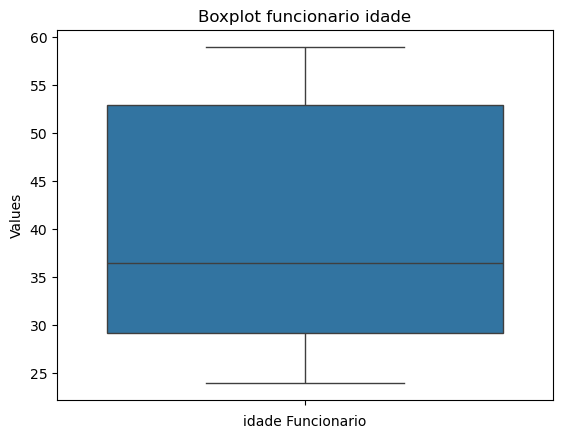

In [88]:
sns.boxplot(y='funcionanrio_idade', data=df)
plt.title('Boxplot funcionario idade')
plt.xlabel('idade Funcionario')
plt.ylabel('Values')
plt.show()

### 5.3.4 Carregar o Dataframe Pandas no BigQuery

In [89]:
cols = df.columns
duplicated_cols = cols[cols.duplicated()]
df.drop(df[duplicated_cols], axis=1, inplace=True)
df.shape

(50, 9)

In [90]:

table_rh_id = f"{project_id}.{dataset_id}.tb_recursos_humanos"

job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)
    
job = client.load_table_from_dataframe(df,table_rh_id, job_config=job_config)
job.result()

LoadJob<project=soulcode-434516, location=US, id=90d61544-a494-4f28-a68a-000c7c53eb94>

In [91]:
query = f"SELECT * FROM `{table_rh_id}`"

query_job = client.query(query)
results = query_job.result().to_dataframe()
results


/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,funcionario_nome,funcionanrio_idade,funcionario_departamento,funcionario_cargo,funcionario_salario,funcionario_data_contratacao,desligamentos_data_desligamento,desligamentos_motivo,avalicao_data_avaliacao
0,Dr. Robert Young,27,TI,Diretor,8608.69,2018-09-30,2023-06-04,Corte de Custos,2023-08-31
1,Dr. Robert Young,27,TI,Diretor,8608.69,2018-09-30,2023-08-27,Corte de Custos,2023-08-31
2,Craig Benton,35,Vendas,Diretor,4306.57,2017-06-30,2023-01-15,Pedido de Demissão,2022-02-28
3,Craig Benton,35,Vendas,Diretor,4306.57,2017-06-30,2023-04-16,Desempenho Insatisfatório,2022-02-28
4,Troy Mitchell,35,Vendas,Diretor,13197.80,2016-08-31,2023-10-01,Pedido de Demissão,2025-01-31
5,Glenda Curry,35,TI,Diretor,4567.12,2016-03-31,2023-10-22,Pedido de Demissão,2024-09-30
6,Glenda Curry,35,TI,Diretor,4567.12,2016-03-31,2023-10-22,Pedido de Demissão,2025-03-31
7,Kenneth Smith,55,Financeiro,Diretor,10955.50,2018-12-31,2023-05-28,Desempenho Insatisfatório,2025-04-30
8,John Hawkins,25,RH,Gerente,5206.83,2019-07-31,2023-06-25,Pedido de Demissão,2022-07-31
9,John Hawkins,25,RH,Gerente,5206.83,2019-07-31,2023-07-02,Pedido de Demissão,2022-07-31


# Referencias
- https://cloud.google.com/bigquery/docs/visualize-jupyter